In [1]:
%pip install matplotlib
%pip install numpy
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import os
import numpy as np

In [3]:
import pandas as pd
import os

def load_and_clean_timeseries(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {file_path}")
    
    df = pd.read_csv(file_path)

    df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')
    
    df['year_month'] = pd.to_datetime(df['year_month'])
    df = df.sort_values('year_month').reset_index(drop=True)
    
    return df

DATA_PATH = os.path.join('..', 'data', 'dataset_demand_acumulate.csv')
try:
    df_demand = load_and_clean_timeseries(DATA_PATH)
    print("Datos cargados y limpios exitosamente.")
    print(df_demand.head())
    print("\nTipos de datos:\n", df_demand.dtypes)
except Exception as e:
    print(f"Error: {e}")

Datos cargados y limpios exitosamente.
  year_month       Demand
0 2017-01-01  1211.009490
1 2017-02-01  1660.584649
2 2017-03-01  3182.587014
3 2017-04-01  3506.515270
4 2017-05-01  4554.082280

Tipos de datos:
 year_month    datetime64[ns]
Demand               float64
dtype: object


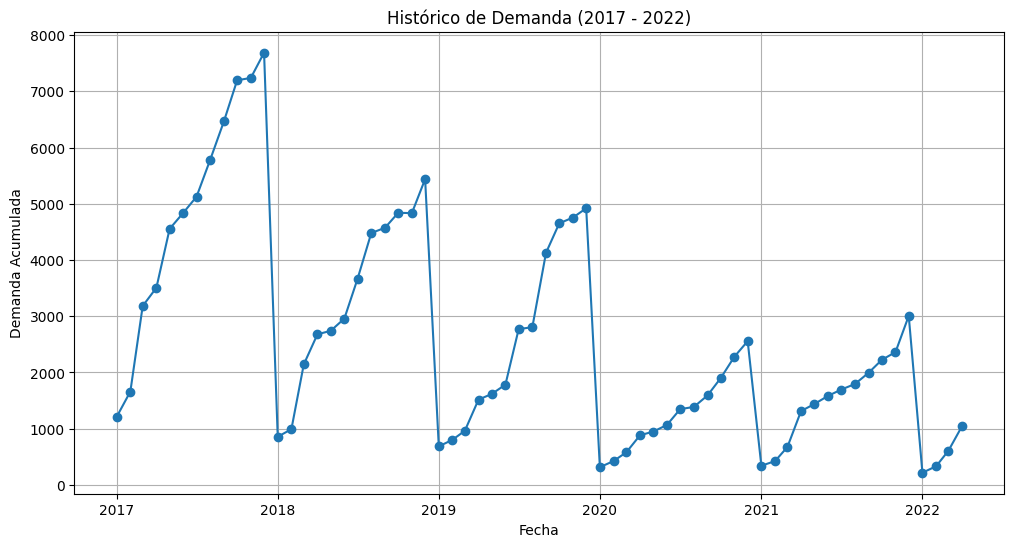

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_demand['year_month'], df_demand['Demand'], marker='o', linestyle='-')
plt.title('Histórico de Demanda (2017 - 2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda Acumulada')
plt.grid(True)
plt.show()

In [5]:
# 1. Preparación de datos (Asegurando que existan TUS variables)
def preparar_datos_originales(df):
    df_full = df.copy().sort_values("year_month")
    
    # --- Las variables que tú definiste ---
    df_full["month"] = df_full["year_month"].dt.month
    df_full["quarter"] = df_full["year_month"].dt.quarter
    df_full["year"] = df_full["year_month"].dt.year
    df_full["is_year_end"] = df_full["month"].isin([11, 12]).astype(int)
    
    # Rolling stats (necesitan shift(1) para no "hacer trampa" con el futuro)
    df_full["rolling_mean_3"] = df_full["Demand"].shift(1).rolling(3).mean()
    df_full["rolling_mean_1"] = df_full["Demand"].shift(1).rolling(1).mean()
    df_full["rolling_mean_6"] = df_full["Demand"].shift(1).rolling(6).mean()
    df_full["rolling_std_3"] = df_full["Demand"].shift(1).rolling(3).std()
    
    # Trend ratio
    df_full["trend_ratio"] = df_full["rolling_mean_3"] / df_full["rolling_mean_6"]
    
    return df_full.dropna()

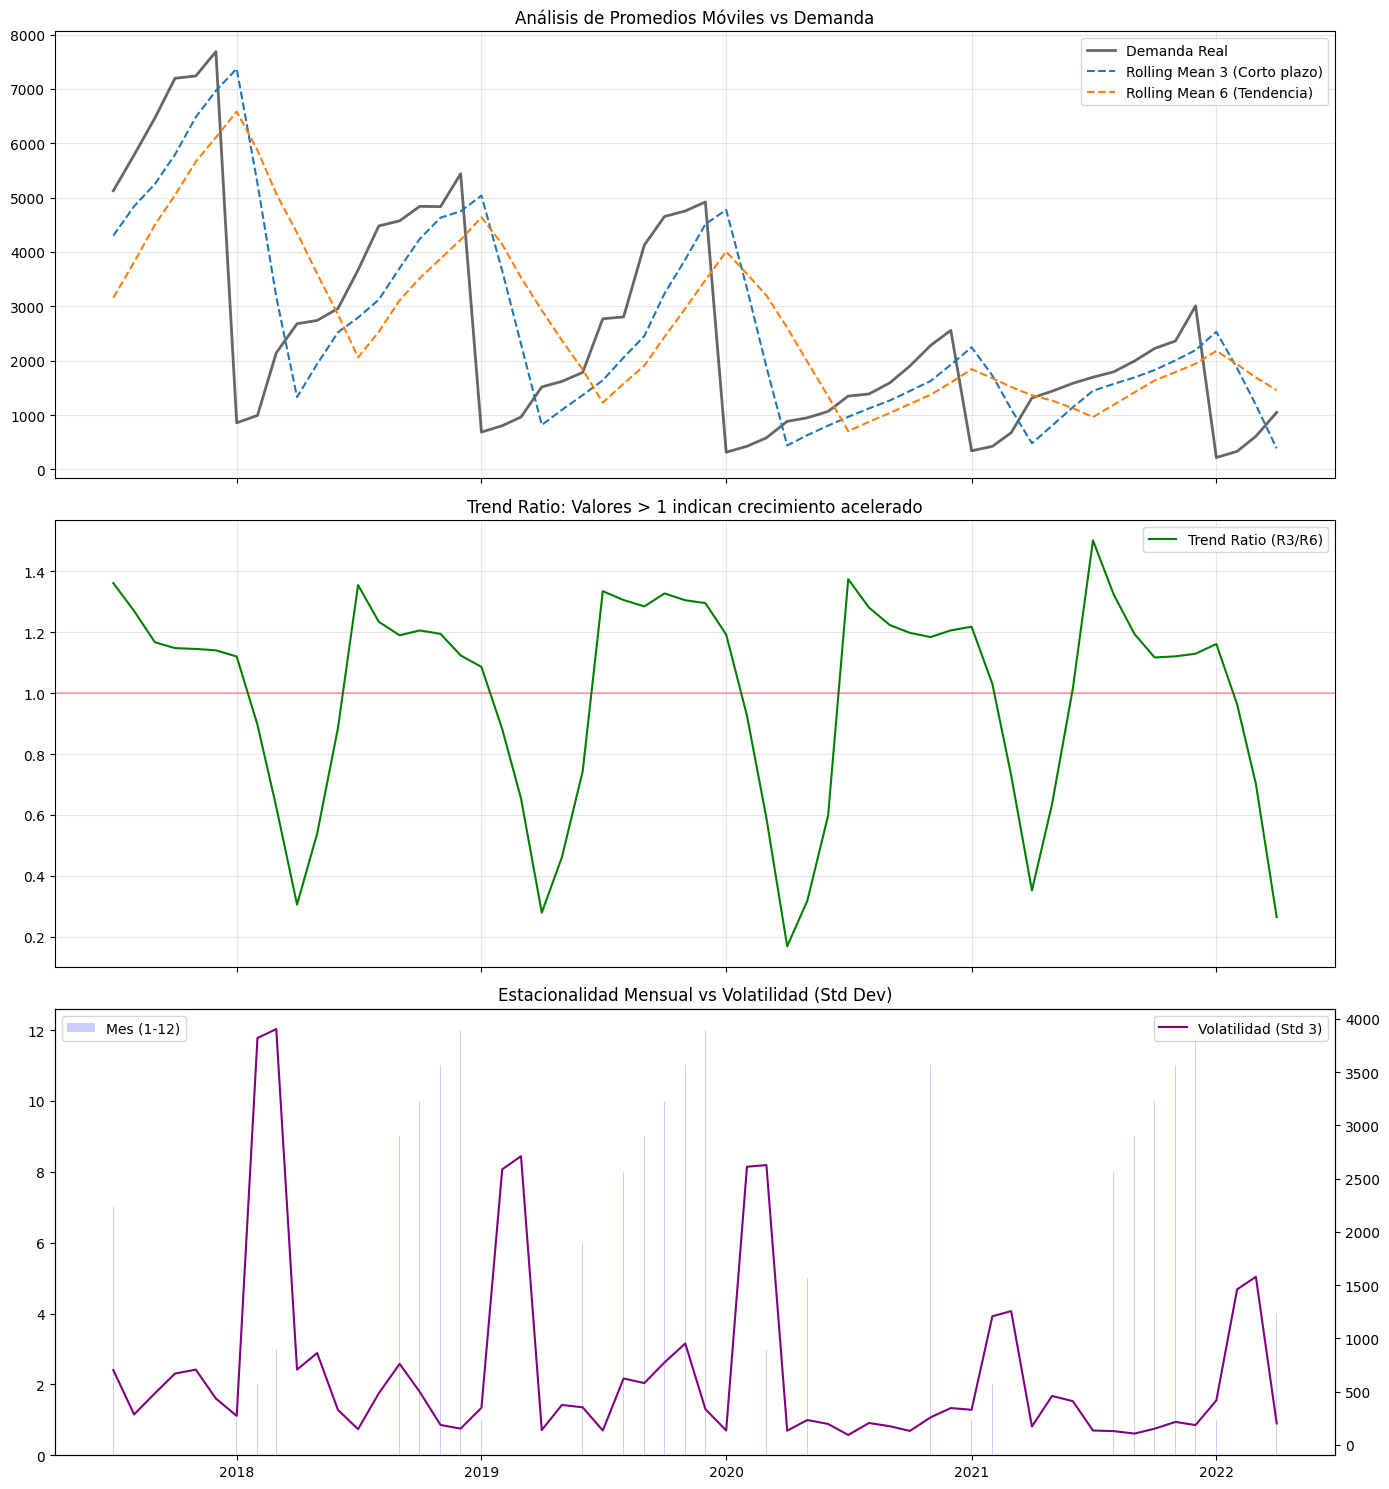

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df_ready = preparar_datos_originales(df_demand)

def graficar_comportamiento_variables(df):
    # Configuramos una rejilla de subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15), sharex=True)
    
    # 1. Demanda vs Promedios Móviles (La "Memoria" del modelo)
    axes[0].plot(df["year_month"], df["Demand"], label="Demanda Real", color="black", linewidth=2, alpha=0.6)
    axes[0].plot(df["year_month"], df["rolling_mean_3"], label="Rolling Mean 3 (Corto plazo)", linestyle="--")
    axes[0].plot(df["year_month"], df["rolling_mean_6"], label="Rolling Mean 6 (Tendencia)", linestyle="--")
    axes[0].set_title("Análisis de Promedios Móviles vs Demanda")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Trend Ratio (¿Qué tan rápido cambia la tendencia?)
    axes[1].plot(df["year_month"], df["trend_ratio"], color="green", label="Trend Ratio (R3/R6)")
    axes[1].axhline(y=1, color='red', linestyle='-', alpha=0.3) # Línea de equilibrio
    axes[1].set_title("Trend Ratio: Valores > 1 indican crecimiento acelerado")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 3. Variables de Calendario vs Volatilidad
    ax3_twin = axes[2].twinx()
    axes[2].bar(df["year_month"], df["month"], alpha=0.2, label="Mes (1-12)", color="blue")
    ax3_twin.plot(df["year_month"], df["rolling_std_3"], color="purple", label="Volatilidad (Std 3)")
    axes[2].set_title("Estacionalidad Mensual vs Volatilidad (Std Dev)")
    axes[2].legend(loc="upper left")
    ax3_twin.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

# Ejecutar la gráfica con tu dataframe procesado
graficar_comportamiento_variables(df_ready)

In [9]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score



# Ejecutamos preparación


# 2. Tu lista exacta de variables
FEATURES_XGB = [
    "month", 
    "quarter", 
    "year", 
    "is_year_end", 
    "rolling_std_3", 
]

# 3. Entrenamiento con XGBoost
def entrenar_xgboost_simple(df):
    train_size = int(len(df) * 0.8)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    X_train, y_train = train[FEATURES_XGB], train["Demand"]
    X_test, y_test = test[FEATURES_XGB], test["Demand"]

    model = XGBRegressor(
        n_estimators=25,
        subsample=1,
        max_depth=5,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # Métricas
    mae = mean_absolute_error(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mae_relativo = (mae / y_train.mean()) * 100
    
    print("\n" + "="*40)
    print("      METRICAS XGBOOST (TUS VARIABLES)")
    print("="*40)
    print(f"R2 Score:     {r2:.4f}")
    print(f"MAPE:         {mape:.2%}")
    print(f"MAE:          {mae:.2f}")
    print(f"MAE Relativo: {mae_relativo:.2f}%")
    print("-" * 40)
    
    return model, test, preds

modelo_xgb, df_res, y_preds = entrenar_xgboost_simple(df_ready)


      METRICAS XGBOOST (TUS VARIABLES)
R2 Score:     0.9293
MAPE:         17.51%
MAE:          178.34
MAE Relativo: 6.35%
----------------------------------------


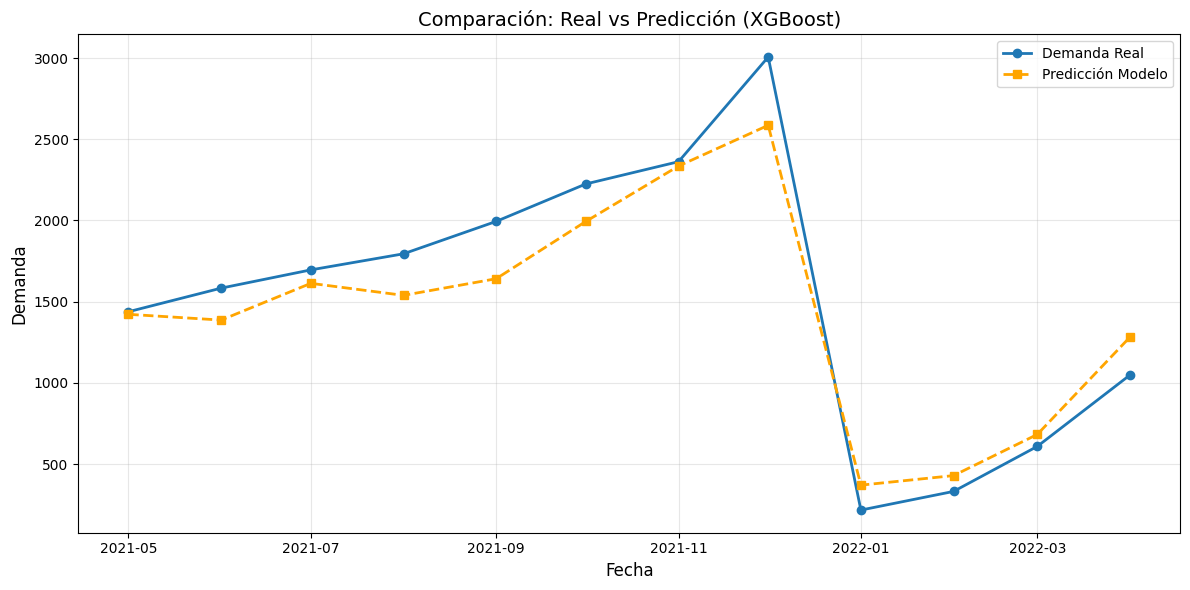

In [10]:
import matplotlib.pyplot as plt

def graficar_resultados(df_test, y_preds, titulo="Comparación: Real vs Predicción (XGBoost)"):
    plt.figure(figsize=(12, 6))
    
    # Graficar valores reales
    plt.plot(df_test["year_month"], df_test["Demand"], 
             marker='o', label="Demanda Real", linewidth=2)
    
    # Graficar predicciones
    plt.plot(df_test["year_month"], y_preds, 
             marker='s', linestyle='--', label="Predicción Modelo", color='orange', linewidth=2)
    
    plt.title(titulo, fontsize=14)
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Demanda", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Llamada a la función
graficar_resultados(df_res, y_preds)

In [12]:
import pandas as pd

def forecast_next_months(df_history, model, n_months=12):
    # Aseguramos que trabajamos con una copia ordenada
    df_forecast = df_history.copy().sort_values("year_month")
    predictions = []

    # Usamos las variables EXACTAS que definiste para XGBoost
    FEATURES_PROYECCION = ["month", "quarter", "year", "is_year_end", "rolling_std_3"]

    for i in range(n_months):
        # 1. Obtener la última fecha y generar la siguiente
        last_date = df_forecast["year_month"].iloc[-1]
        next_date = last_date + pd.DateOffset(months=1)

        # 2. Extraer variables de calendario
        month = next_date.month
        quarter = next_date.quarter
        year = next_date.year
        is_year_end = int(month in [11, 12])

        # 3. Calcular estadísticas móviles (rolling_std_3)
        # Tomamos los últimos 3 valores de "Demand" para la desviación estándar
        last_3_demands = df_forecast["Demand"].iloc[-3:]
        rolling_std_3 = last_3_demands.std()

        # 4. Crear el DataFrame de entrada para el modelo
        X_next = pd.DataFrame([{
            "month": month,
            "quarter": quarter,
            "year": year,
            "is_year_end": is_year_end,
            "rolling_std_3": rolling_std_3
        }])

        # 5. Realizar la predicción con el modelo XGBoost
        # Aseguramos el orden correcto de las columnas
        pred = model.predict(X_next[FEATURES_PROYECCION])[0]

        # Evitar valores negativos si el modelo se desvía
        pred = max(0, pred)

        # 6. Guardar el resultado para el reporte final
        predictions.append({
            "year_month": next_date,
            "Predicted_Demand": pred
        })

        # 7. IMPORTANTE: Alimentar el dataframe con la nueva predicción 
        # para que el siguiente mes pueda calcular su 'rolling_std_3'
        df_forecast = pd.concat([
            df_forecast,
            pd.DataFrame([{"year_month": next_date, "Demand": pred}])
        ], ignore_index=True)

    return pd.DataFrame(predictions)

# Llamada a la función con tu nuevo modelo
df_final_forecast = forecast_next_months(df_demand, modelo_xgb, n_months=12)

print("PROYECCIÓN DE LOS PRÓXIMOS 12 MESES")
print("-" * 35)
print(df_final_forecast)

PROYECCIÓN DE LOS PRÓXIMOS 12 MESES
-----------------------------------
   year_month  Predicted_Demand
0  2022-05-01       1384.591797
1  2022-06-01       1386.805786
2  2022-07-01       1619.505371
3  2022-08-01       1557.652710
4  2022-09-01       1641.376831
5  2022-10-01       1964.851807
6  2022-11-01       2334.877441
7  2022-12-01       2585.820557
8  2023-01-01        351.603119
9  2023-02-01        429.516602
10 2023-03-01        682.756287
11 2023-04-01       1294.532715


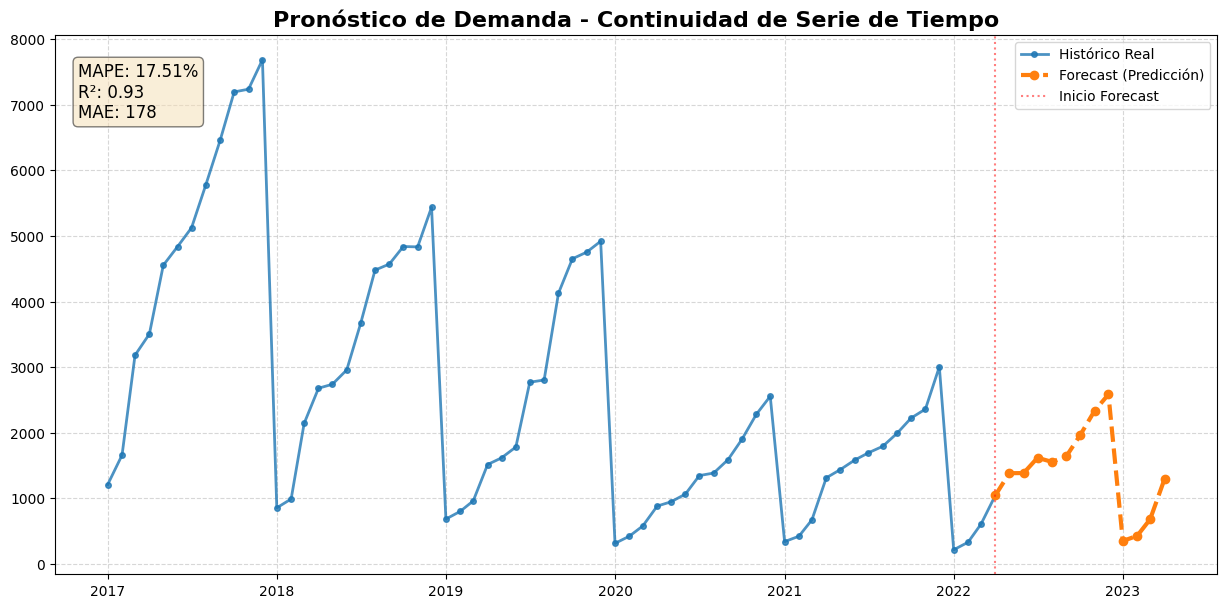

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# 1. Preparación de datos para la continuidad de la línea
last_real_point = df_demand.tail(1)[['year_month', 'Demand']].copy()
last_real_point.columns = ['year_month', 'Predicted_Demand']
forecast_plot = pd.concat([last_real_point, df_final_forecast]).reset_index(drop=True)

# 2. CÁLCULO DE MÉTRICAS (Para evitar el NameError)
# Usamos df_res["Demand"] que son los valores reales de prueba y y_preds que son las predicciones
mape_val = mean_absolute_percentage_error(df_res["Demand"], y_preds)
r2_val = r2_score(df_res["Demand"], y_preds)
mae_val = mean_absolute_error(df_res["Demand"], y_preds)

plt.figure(figsize=(15, 7))

# 3. Graficar Histórico
plt.plot(df_demand["year_month"], df_demand["Demand"], label="Histórico Real", 
         color='#1f77b4', linewidth=2, marker='o', markersize=4, alpha=0.8)

# 4. Graficar Forecast
plt.plot(forecast_plot["year_month"], forecast_plot["Predicted_Demand"], label="Forecast (Predicción)", 
         color='#ff7f0e', linestyle="--", linewidth=3, marker="o", markersize=6)

# 5. Cuadro de texto con las métricas calculadas arriba
textstr = '\n'.join((
    f'MAPE: {mape_val:.2%}', 
    f'R²: {r2_val:.2f}',
    f'MAE: {mae_val:.0f}'
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)

# 6. Estética
plt.title("Pronóstico de Demanda - Continuidad de Serie de Tiempo", fontsize=16, fontweight='bold')
plt.axvline(x=df_demand["year_month"].iloc[-1], color='red', linestyle=':', alpha=0.5, label='Inicio Forecast')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [16]:
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

meses_pedidos = ['2022-05-01', '2022-06-01', '2022-07-01']
df_target_forecast = df_final_forecast[df_final_forecast['year_month'].isin(pd.to_datetime(meses_pedidos))].copy()

print("--- Pronóstico de Demanda para Entrega ---")
print(df_target_forecast)



--- Pronóstico de Demanda para Entrega ---
  year_month  Predicted_Demand
0 2022-05-01           1384.59
1 2022-06-01           1386.81
2 2022-07-01           1619.51
